In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os 
import glob
import cv2
import tensorflow as tf
# import tensorflow_hub as hub
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')

## Data Preprocessing

In [ ]:
# train_path = r"/kaggle/input/nn23-sports-image-classification/Train"
# test_path =r"/kaggle/input/nn23-sports-image-classification/Test"
train_path = r"../nn23-sports-image-classification/Train"
test_path =r"../nn23-sports-image-classification/Test"

In [34]:
train_imgs=os.listdir(train_path)
test_imgs=os.listdir(test_path)

In [35]:
code = {'Basketball' : 0 , 'Football' : 1 , 'Rowing' : 2 , 'Swimming' :3 ,"Tennis" : 4 , "Yoga" : 5}

def get_name(n):

    for x,y in code.items() :
        if y == n :
            return x

In [36]:
#get labels for training
train_labels = []

for cur_img in train_imgs:
    if "Basketball" in cur_img :
        label = (code["Basketball"])
    elif "Football" in cur_img :
        label = (code["Football"])
    elif "Rowing" in cur_img :
        label = (code["Rowing"])
    elif "Swimming" in cur_img :
        label = (code["Swimming"])
    elif "Tennis" in cur_img :
        label = (code["Tennis"])
    elif "Yoga" in cur_img :
        label = (code["Yoga"])

    train_labels.append(label)

In [37]:
#reading images 
def reading_resize(train_imgs,train_path,image_size):
    l=[]
    for g in train_imgs:   
        img_path=os.path.join(train_path,g)
        img=cv2.imread(img_path)   
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        res = cv2.resize(img, (image_size, image_size))
        l.append(res)
        
    return l

In [38]:
#reading training data
image_size=224
l_train=reading_resize(train_imgs,train_path,image_size)

In [39]:
train = np.array(l_train)
labels=np.array(train_labels)
print(train.shape)

(1681, 224, 224, 3)


Basketball


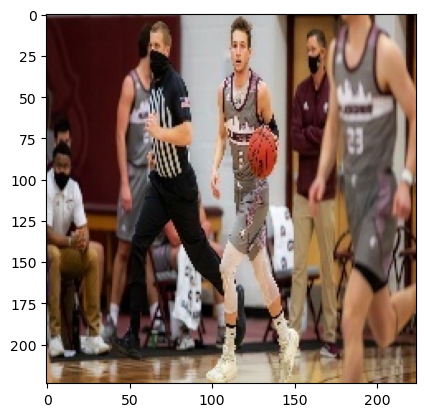

In [40]:
plt.imshow(train[0])
print(get_name(labels[0]))

In [41]:
pd.DataFrame(labels).value_counts()

5    458
1    400
3    240
2    202
0    196
4    185
dtype: int64

In [42]:
X_train, X_val, y_train, y_val = train_test_split(train , labels, test_size = 0.2,stratify=labels,shuffle=True)

X_train =X_train/255.0
X_val =X_val/255.0

In [43]:
# Train labels
y_train=tf.keras.utils.to_categorical(y_train)

# Test labels
y_val=tf.keras.utils.to_categorical(y_val)

In [44]:
y_train.shape

(1344, 6)

Basketball


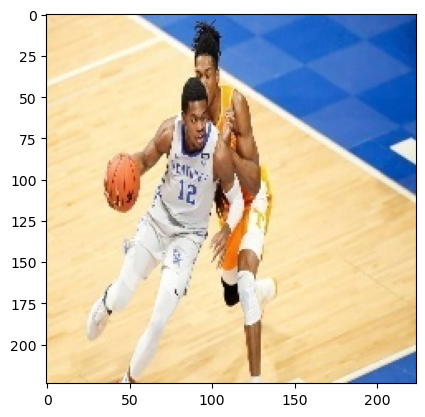

In [45]:
plt.imshow(X_train[0])
print(get_name(np.argmax(y_train[0])))

## Model [mobilenet_v2 224x224]

In [46]:
def Convolution(Input, FC, alpha, kernel=(3, 3), stride=(1, 1)):

    # channels_axis = -1 if channels_last || 1 if channels_first
    channels_axis = -1

    # alpha enable to change the filter count <FC>
    FC = int(FC * alpha)

    # padding: Int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
    # If int: the same symmetric padding is applied to height and width.
    # If tuple of 2 ints: interpreted as two different symmetric padding values for height and width: (symmetric_height_pad, symmetric_width_pad).
    # If tuple of 2 tuples of 2 ints: interpreted as ((top_pad, bottom_pad), (left_pad, right_pad))
    x = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv1_pad')(Input) 

    # padding = 'valid' where no padding applied or 'same' results in padding with zeros evenly to the left/right or up/down of the input
    x = tf.keras.layers.Conv2D(FC, kernel,padding='valid',use_bias=False,strides=stride,name='conv1')(x)
 
    # Batch-Normalization (BN) is an algorithmic method which makes the training of Deep Neural Networks (DNN) faster and more stable.
    # It consists of normalizing activation vectors from hidden layers using the first and the second statistical moments (mean and variance) of the current batch. 
    # steps:=
    # 1) The BN layer first determines the mean 𝜇 and the variance σ² of the activation values across the batch.
    # 2) Then normalizes the activation vector.
    # 3)  finally calculates the layer’s output by applying a linear transformation with 𝛾 and 𝛽, two trainable parameters.
    # Such step allows the model to choose the optimum distribution for each hidden layers, by adjusting those two parameters.
    # 𝛾 ==> allows to adjust the standard deviation.
    # 𝛽 ==> allows to adjust the bias, shifting the curve on the right or on the left side.  
    x = tf.keras.layers.BatchNormalization(axis=channels_axis, name='conv1_bn')(x)

    
    # With default values, it returns element-wise max(x, 0).
    # Otherwise, it follows: f(x) = max_value for x >= max_value, 
    #                        f(x) = x for threshold <= x < max_value, 
    #                        f(x) = negative_slope * (x - threshold) otherwise.
    # default: max_value=None, negative_slope=0.0, threshold=0.0
    x =tf.keras.layers.ReLU(6.0, name='conv1_relu')(x) 

    return x

In [47]:
def DepthwiseConvolutionBlock(Input, FC_pointwise_conv, alpha,depth_multiplier=1, stride=(1, 1), block_id=1):

    # channels_axis = -1 if channels_last || 1 if channels_first
    channels_axis = -1 

    # alpha enable to change the filter count <FC>
    FC_pointwise_conv = int(FC_pointwise_conv * alpha)

    if stride == (1, 1):
        x = Input
    else:
        x = tf.keras.layers.ZeroPadding2D(((0, 1), (0, 1)),name='conv_pad_%d' % block_id)(Input)

    #========= first apply DEPTH WISE CONVOLUTION    
    # depth_multiplier: The number of depthwise convolution output channels for each input channel. 
    # The total number of depthwise convolution output channels will be equal to filters_in * depth_multiplier.
    x = tf.keras.layers.DepthwiseConv2D((3, 3),padding='same' if stride == (1, 1) else 'valid',depth_multiplier=depth_multiplier,strides=stride,use_bias=False,name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(axis=channels_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(6.0, name='conv_dw_%d_relu' % block_id)(x)

    #========= second apply POINT WISE CONVOLUTION
    x = tf.keras.layers.Conv2D(FC_pointwise_conv, (1, 1),padding='same',use_bias=False,strides=(1, 1),name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(axis=channels_axis,name='conv_pw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(6.0, name='conv_pw_%d_relu' % block_id)(x)
    
    return x

In [48]:
input_shape=(224,224,3)
alpha=1.0                           
depth_multiplier=1                   
dropout=0.001               
classes=1000

In [49]:
InputLayer = tf.keras.layers.Input(shape=input_shape)
x = Convolution(InputLayer, 32, alpha, stride=(2, 2))
x = DepthwiseConvolutionBlock(x, 64, alpha, depth_multiplier, block_id=1)
x = DepthwiseConvolutionBlock(x, 128, alpha, depth_multiplier,stride=(2, 2), block_id=2)
x = DepthwiseConvolutionBlock(x, 128, alpha, depth_multiplier, block_id=3)
x = DepthwiseConvolutionBlock(x, 256, alpha, depth_multiplier, stride=(2, 2), block_id=4)
x = DepthwiseConvolutionBlock(x, 256, alpha, depth_multiplier, block_id=5)
x = DepthwiseConvolutionBlock(x, 512, alpha, depth_multiplier,stride=(2, 2), block_id=6)
x = DepthwiseConvolutionBlock(x, 512, alpha, depth_multiplier, block_id=7)
x = DepthwiseConvolutionBlock(x, 512, alpha, depth_multiplier, block_id=8)
x = DepthwiseConvolutionBlock(x, 512, alpha, depth_multiplier, block_id=9)
x = DepthwiseConvolutionBlock(x, 512, alpha, depth_multiplier, block_id=10)
x = DepthwiseConvolutionBlock(x, 512, alpha, depth_multiplier, block_id=11)
x = DepthwiseConvolutionBlock(x, 1024, alpha, depth_multiplier,stride=(2, 2), block_id=12)
x = DepthwiseConvolutionBlock(x, 1024, alpha, depth_multiplier, block_id=13)

In [50]:
shape = (1, 1, int(1024 * alpha))

In [51]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Reshape(shape, name='reshape_1')(x)
x = tf.keras.layers.Dropout(dropout, name='dropout')(x)
x = tf.keras.layers.Conv2D(classes, (1, 1),padding='same',name='conv_preds')(x)
x = tf.keras.layers.Reshape((classes,), name='reshape_2')(x)
x = tf.keras.layers.Activation('softmax', name='act_softmax')(x)

In [52]:
# Create model.
model = tf.keras.models.Model(InputLayer, x, name='mobilenet_%0.2f_%s' % (alpha, 224))

In [55]:
# Load weights.
# model.load_weights('/kaggle/input/weights-data/weights.h5')
model.load_weights('weights_mobilenetv2.h5')

In [56]:
len(model.layers)

93

In [57]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 225, 225, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                

                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9

In [58]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [59]:
classes = 6
model2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((224,224,3)),
    model,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(classes)
])

In [60]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1000)             4253864   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 6)                 6006      
                                                                 
Total params: 4,259,870
Trainable params: 4,237,982
Non-trainable params: 21,888
_________________________________________________________________


In [61]:
model2.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

## Training without Augmentation 

In [1]:
Epochs=100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = model2.fit(X_train,y_train,
                    epochs=Epochs,
                    validation_data=(X_val,y_val),
                    batch_size=32,
                    verbose=1)#,callbacks=[early_stopping]

In [ ]:
history.history.keys()

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model2.evaluate(X_train,y_train)

In [ ]:
model2.evaluate(X_val,y_val)

## Saving the model

In [ ]:
saved_keras_model_filepath = '/kaggle/working/{}.h5'.format("sports image classification using mobilenet without Augmentation")
model2.save(saved_keras_model_filepath)

## Training with Augmentation 

In [ ]:
train_generator = ImageDataGenerator(    
    rotation_range=0.5,
    width_shift_range=0.2,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

In [ ]:
Epochs=100
Batch_size=32
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = model2.fit(train_generator.flow(X_train,y_train,batch_size=Batch_size,seed=27,shuffle=False),
                    epochs=Epochs,
                    steps_per_epoch=X_train.shape[0] // Batch_size,
                    validation_data=(X_val,y_val),
                    verbose=1)

In [ ]:
history.history.keys()

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model2.evaluate(X_train,y_train)

In [ ]:
model2.evaluate(X_val,y_val)

## Saving the model

In [ ]:
saved_keras_model_filepath = '/kaggle/working/{}.h5'.format("sports image classification using mobilenet with Augmentation")
model2.save(saved_keras_model_filepath)

## Load the model

In [ ]:
reloaded_keras_model=tf.keras.models.load_model('/kaggle/input/model-station1/model station1.h5')
reloaded_keras_model.summary()

## Predict our test data

In [ ]:
test_path =r"/kaggle/input/nn23-sports-image-classification/Test"
test_imgs=os.listdir(test_path)

In [ ]:
# reading test data
l_test=reading_resize(test_imgs,test_path,image_size)

In [ ]:
test = np.array(l_test)
print(test.shape)

In [ ]:
plt.imshow(test[200])

In [ ]:
test_names=[]
for g in test_imgs:   
    test_names.append(g)

In [ ]:
len(test_names)

In [ ]:
#normalize
test=test/255.0

In [ ]:
test_out=reloaded_keras_model.predict(test)

In [ ]:
#pred
p=test_out

plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test[i])
    plt.xlabel(get_name(np.argmax(p[i])))
plt.show()

In [ ]:
pred_out=[]
for i in range(len(test_out)):
    label=np.argmax(test_out[i])
    pred_out.append([test_names[i],label])

In [ ]:
# pred_out

In [ ]:
Datapd=pd.DataFrame(pred_out,columns=['image_name','label'])
Datapd.head()

In [ ]:
Datapd.to_csv('/kaggle/working/sports_6_classs_preds__.csv',index=False)